In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import evds as ev
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch.unitroot import ADF, KPSS
import pymannkendall as mk
from pmdarima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm
from merlion.models.utils.autosarima_utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose
import copy
import itertools
import warnings

# Suppressing warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading the dataset and parsing dates, setting the 'date' column as the index
# Resampling the data to daily frequency and interpolating missing values
orders = pd.read_csv("data-train.csv", parse_dates=["date"], index_col="date").asfreq("D").interpolate()

# Displaying the orders dataframe
orders


,orders,temperature,media_spend
date,,,
2020-05-02,54,18.270322,0.0
2020-05-03,63,19.882444,0.0
2020-05-04,56,16.878095,0.0
2020-05-05,65,21.878648,0.0
2020-05-06,64,21.112398,0.0
...,...,...,...
2022-06-12,76,11.472592,0.0
2022-06-13,78,11.643281,0.0
2022-06-14,79,11.813969,0.0


In [3]:
# Reading the unseen features dataset and parsing dates, setting the 'date' column as the index
# Resampling the data to daily frequency and interpolating missing values
orders_unseen = pd.read_csv("data-unseen-features.csv", parse_dates=["date"], index_col="date").asfreq("D").interpolate()

# Displaying the orders_unseen dataframe
orders_unseen

,temperature,media_spend
date,,
2022-06-17,11.923126,0.000000
2022-06-18,14.986238,0.000000
2022-06-19,11.003947,0.000000
2022-06-20,12.699259,0.000000
2022-06-21,17.852300,0.000000
2022-06-22,11.601299,0.000000
2022-06-23,16.207998,14.847883
2022-06-24,12.952067,0.000000
2022-06-25,9.284319,14.664207


In [4]:
# Displaying information about the orders dataframe
orders.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 776 entries, 2020-05-02 to 2022-06-16
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   orders       776 non-null    int64  
 1   temperature  776 non-null    float64
 2   media_spend  776 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 24.2 KB


In [5]:
# Displaying the number of missing values in the orders dataframe
orders.isnull().sum()

orders         0
temperature    0
media_spend    0
dtype: int64

In [6]:
# Displaying the number of missing values in the orders_unseen dataframe
orders_unseen.isnull().sum()

temperature    0
media_spend    0
dtype: int64

In [7]:
# Displaying unique value counts for each column in the orders dataframe
for col in orders.columns:
    print(f"--- {col} ---")
    print(orders[col].value_counts().sort_index().to_string())
    print("\n")

--- orders ---
orders
40       1
42       1
44       1
46       1
47       2
48       3
49       3
50       3
51       5
52       1
53       3
54       8
55       7
56      12
57       7
58      11
59       6
60      13
61      14
62      16
63      13
64      14
65      14
66      21
67      18
68      13
69      12
70      19
71      17
72      16
73      19
74      14
75      19
76      19
77      33
78      24
79      28
80      31
81      21
82      25
83      24
84      23
85      20
86      20
87      15
88      19
89      18
90      24
91      20
92      11
93       6
94       8
95      10
96       9
97       5
98       5
99       7
100      3
101      2
102      5
103      3
105      1
106      4
107      1
111      1
113      1
2816     1
2952     1
4080     1


--- temperature ---
temperature
-9.979354     1
-8.724605     1
-8.020228     1
-7.068919     1
-6.766936     1
-6.455385     1
-6.389087     1
-6.358665     1
-5.946211     1
-5.685818     1
-5.660821     1
-5.532648

In [8]:
# # Replacing all values in the 'media_spend' column with 0 for the orders dataframe
# orders['media_spend'] = 0

# # Replacing all values in the 'media_spend' column with 0 for the orders_unseen dataframe
# orders_unseen['media_spend'] = 0

# # Displaying the orders dataframe after replacing values in the 'media_spend' column with 0
# orders

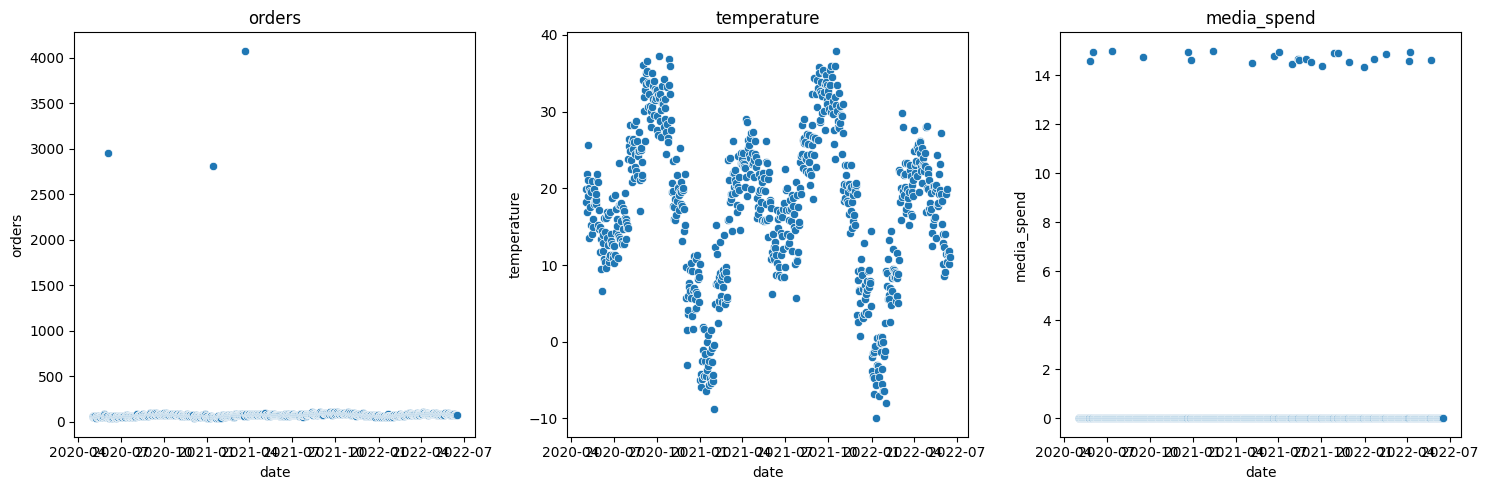

In [9]:
# Create subplots to display scatter plots of all columns side by side
fig, axs = plt.subplots(1, len(orders.columns), figsize=(15, 5))

# Place each scatter plot in a separate subplot for each column
for i, col in enumerate(orders.columns):
    sns.scatterplot(x=orders.index, y=orders[col], ax=axs[i])
    axs[i].set_title(col)

# Adjust subplot layout
plt.tight_layout()
plt.show()

In [10]:
# Threshold value set by the user
threshold_value = 1000

# Filter the rows in the 'orders' DataFrame where the 'orders' column value is greater than or equal to the threshold value
orders_outlier = orders[orders['orders'] >= threshold_value]

# Display the filtered DataFrame containing rows with outlier values
orders_outlier

,orders,temperature,media_spend
date,,,
2020-06-03,2952,9.493584,0.0
2021-01-14,2816,-4.468595,0.0
2021-03-22,4080,20.155265,0.0


In [11]:
# Set specific values in the 'orders' column to NaN for the specified dates
orders["orders"].loc[["2020-06-03", "2021-01-14", "2021-03-22"]] = np.NaN

# Display the rows corresponding to the specified dates in the DataFrame
orders.loc[["2020-06-03", "2021-01-14", "2021-03-22"]]

,orders,temperature,media_spend
date,,,
2020-06-03,NaN,9.493584,0.0
2021-01-14,NaN,-4.468595,0.0
2021-03-22,NaN,20.155265,0.0


In [12]:
# Perform linear interpolation to fill missing values in the 'orders' column
orders['orders'] = orders['orders'].interpolate()

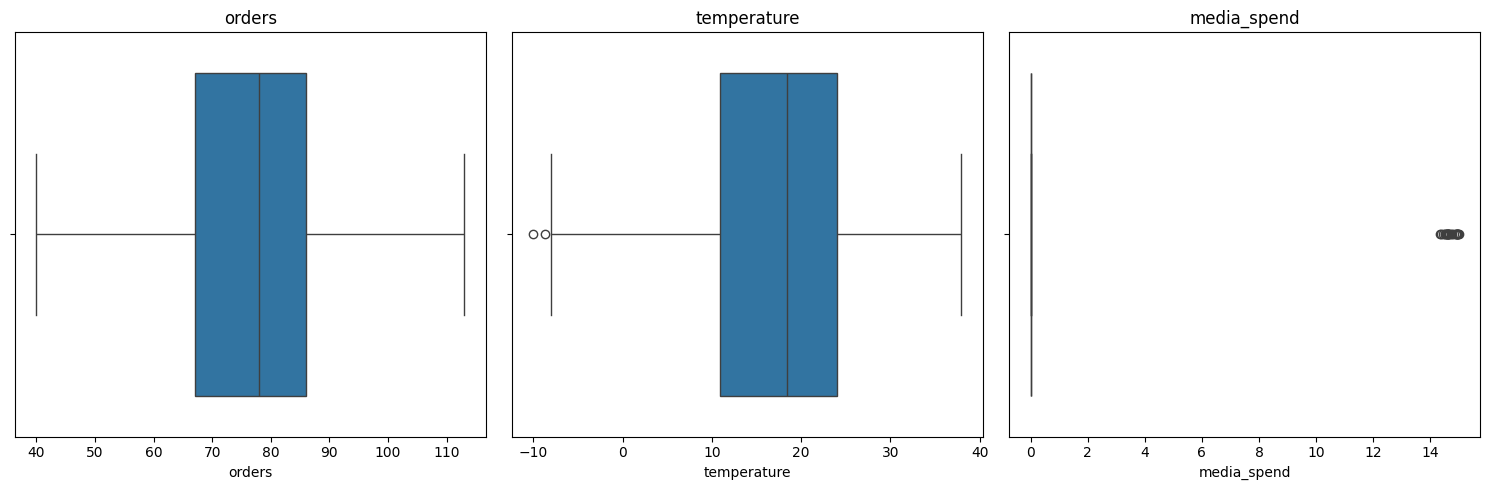

In [13]:
# Create subplots to display boxplots of all columns side by side
fig, axs = plt.subplots(1, len(orders.columns), figsize=(15, 5))

# Place each boxplot in a separate subplot for each column
for i, col in enumerate(orders.columns):
    sns.boxplot(x=orders[col], ax=axs[i])
    axs[i].set_title(col)

# Adjust subplot layout
plt.tight_layout()
plt.show()

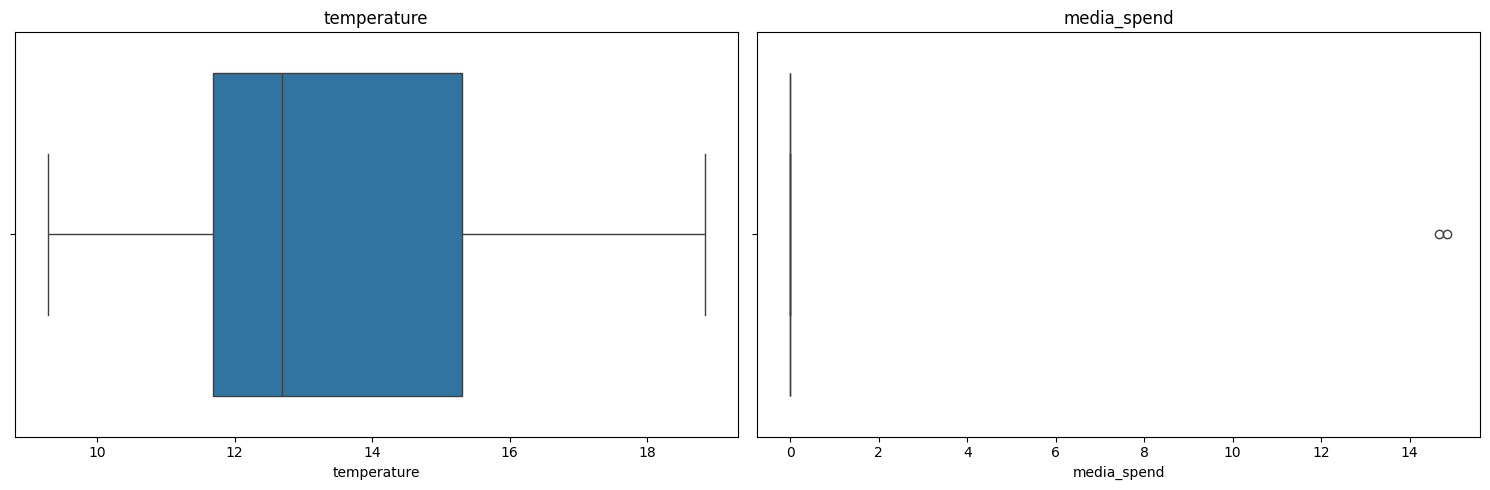

In [14]:
# Create subplots to display boxplots of all columns side by side
fig, axs = plt.subplots(1, len(orders_unseen.columns), figsize=(15, 5))

# Place each boxplot in a separate subplot for each column
for i, col in enumerate(orders_unseen.columns):
    sns.boxplot(x=orders_unseen[col], ax=axs[i])
    axs[i].set_title(col)

# Adjust subplot layout
plt.tight_layout()
plt.show()

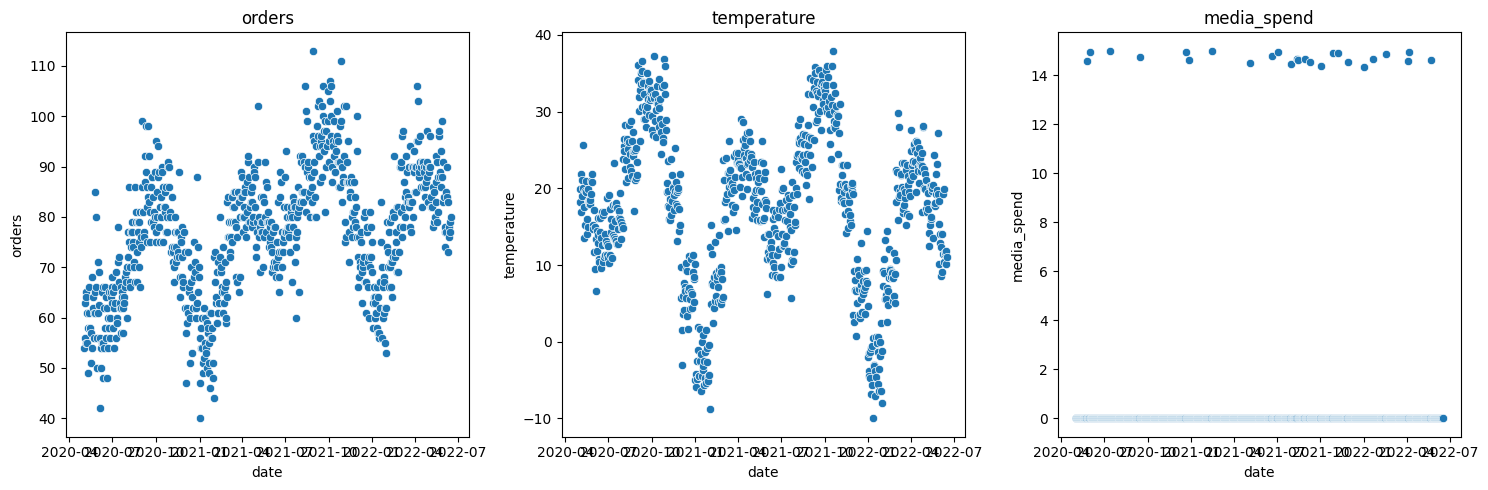

In [15]:
# Create subplots to display scatter plots of all columns side by side
fig, axs = plt.subplots(1, len(orders.columns), figsize=(15, 5))

# Place each scatter plot in a separate subplot for each column
for i, col in enumerate(orders.columns):
    sns.scatterplot(x=orders.index, y=orders[col], ax=axs[i])
    axs[i].set_title(col)

# Adjust subplot layout
plt.tight_layout()
plt.show()

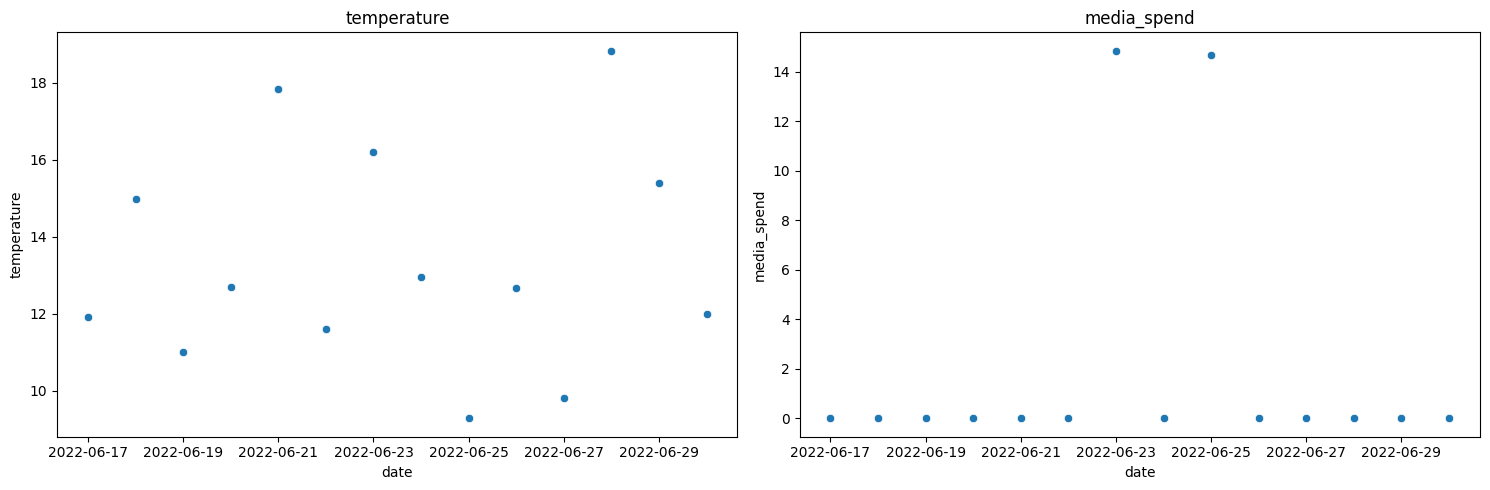

In [16]:
# Create subplots to display scatter plots of all columns side by side
fig, axs = plt.subplots(1, len(orders_unseen.columns), figsize=(15, 5))

# Place each scatter plot in a separate subplot for each column
for i, col in enumerate(orders_unseen.columns):
    sns.scatterplot(x=orders_unseen.index, y=orders_unseen[col], ax=axs[i])
    axs[i].set_title(col)

# Adjust subplot layout
plt.tight_layout()
plt.show()

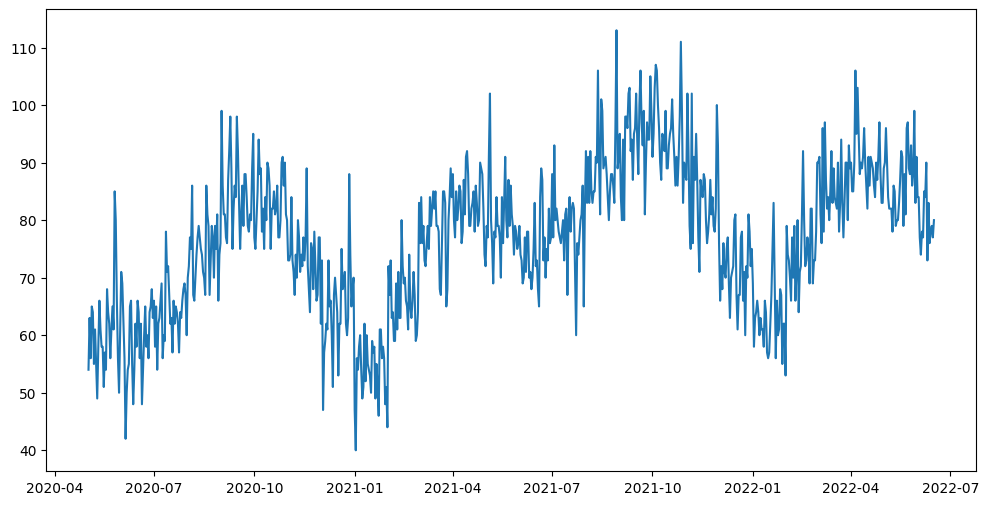

In [17]:
# Create a figure with a specific size to display the plot
plt.figure(figsize=(12,6))

# Plot the 'orders' column from the 'orders' dataframe
plt.plot(orders["orders"])

# Show the plot
plt.show()

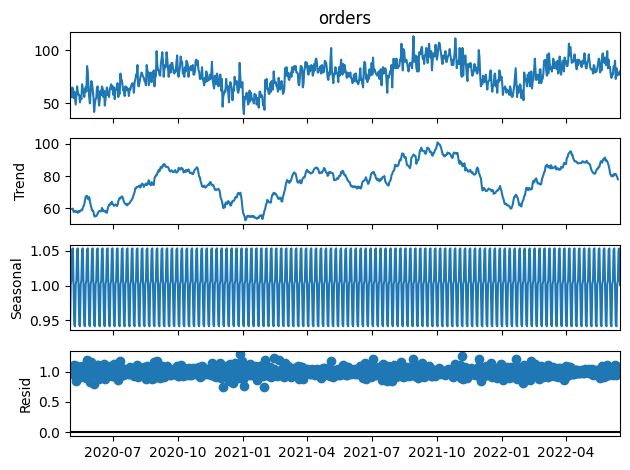

In [18]:
sd = seasonal_decompose(orders["orders"], model="mul", period=7).plot()

In [19]:
# Make a copy of the orders data
data = copy.deepcopy(orders)

# Add a column for the day of the week
data["Day of Week"] = data.index.dayofweek

# Add a column for the months
data["Months"] = data.index.month

# Display the modified data
data

,orders,temperature,media_spend,Day of Week,Months
date,,,,,
2020-05-02,54.0,18.270322,0.0,5,5
2020-05-03,63.0,19.882444,0.0,6,5
2020-05-04,56.0,16.878095,0.0,0,5
2020-05-05,65.0,21.878648,0.0,1,5
2020-05-06,64.0,21.112398,0.0,2,5
...,...,...,...,...,...
2022-06-12,76.0,11.472592,0.0,6,6
2022-06-13,78.0,11.643281,0.0,0,6
2022-06-14,79.0,11.813969,0.0,1,6


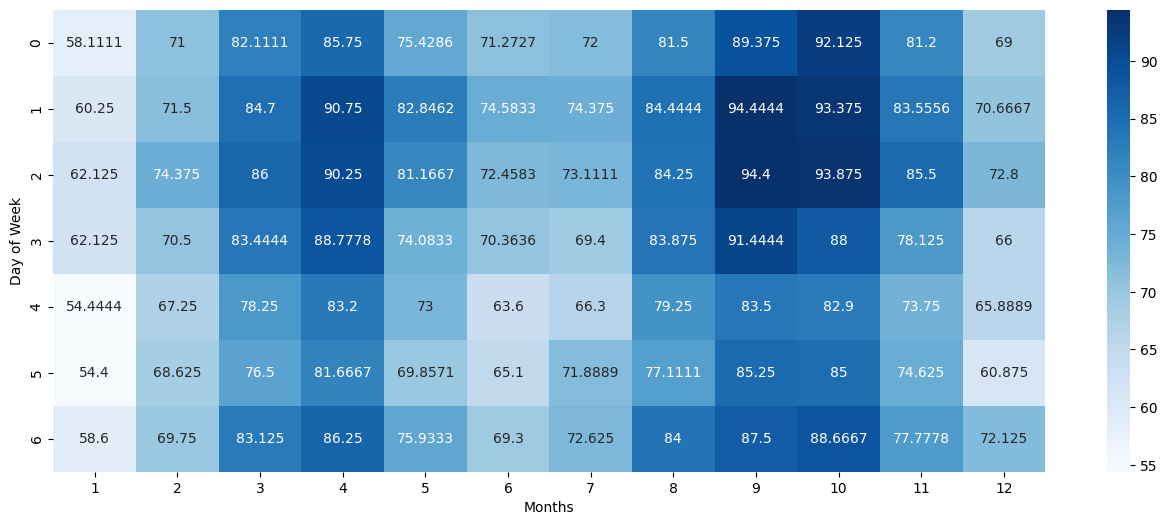

In [20]:
# Create a figure for the heatmap with specific size
plt.figure(figsize=(16, 6))

# Create a pivot table from the data
matrix = pd.pivot_table(data, values="orders", index="Day of Week", columns="Months")

# Define colors for the heatmap
colors = sns.color_palette("Blues", as_cmap=True)

# Plot the heatmap
sns.heatmap(matrix, annot=True, fmt="g", cmap=colors)

# Show the heatmap
plt.show()

In [21]:
# Calculate the correlation matrix for the 'orders' dataframe
orders.corr()

,orders,temperature,media_spend
orders,1.000000,0.726183,0.239470
temperature,0.726183,1.000000,0.014082
media_spend,0.239470,0.014082,1.000000


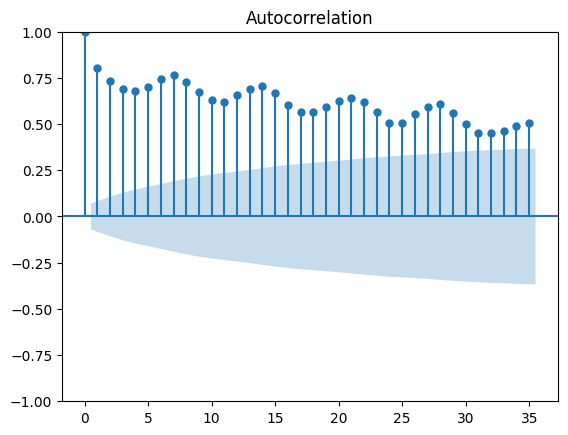

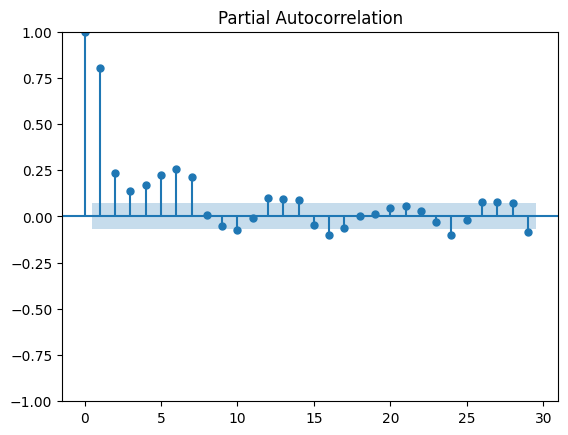

In [22]:
# Plot the autocorrelation function (ACF) for the 'orders' column with lag values up to 35
plot_acf(orders["orders"], lags=35)

# Plot the partial autocorrelation function (PACF) for the 'orders' column
plot_pacf(orders["orders"])

# Show the plots
plt.show()

In [23]:
# Splitting the orders dataframe into training and testing sets
# Training set: all rows except the last 14 days
data_train = orders.iloc[:-14]

# Testing set: last 14 days
data_test = orders.iloc[-14:]

# Displaying the testing set
data_test

,orders,temperature,media_spend
date,,,
2022-06-03,77.0,14.021126,0.0
2022-06-04,74.0,8.557476,0.0
2022-06-05,78.0,12.326819,0.0
2022-06-06,77.0,14.085052,0.0
2022-06-07,85.0,9.062854,0.0
2022-06-08,84.0,11.424545,0.0
2022-06-09,90.0,19.228510,0.0
2022-06-10,73.0,10.436454,0.0
2022-06-11,83.0,19.877631,0.0


In [24]:
# Applying the Mann-Kendall original test to detect trend in the 'orders' column
mk.original_test(data_train["orders"])

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=13.349935120241595, Tau=0.32305193125497944, s=93666.0, var_s=49226206.0, slope=0.02800658978583196, intercept=67.34349258649094)

In [25]:
# Applying the Augmented Dickey-Fuller (ADF) test to check for stationarity in the 'orders' column
adf = ADF(data_train["orders"])

# Applying the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test to check for stationarity in the 'orders' column
kpss = KPSS(data_train["orders"])

# Printing the results of the ADF and KPSS tests
print(adf)
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.342
P-value                         0.159
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  1.392
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [26]:
# Fitting Ordinary Least Squares (OLS) regression model using statsmodels
model_sm = sm.OLS(endog=data_train["orders"], exog=data_train[["temperature", "media_spend"]]).fit()

# Printing the summary of the OLS regression model
print(model_sm.summary())

                                 OLS Regression Results                                
Dep. Variable:                 orders   R-squared (uncentered):                   0.845
Model:                            OLS   Adj. R-squared (uncentered):              0.844
Method:                 Least Squares   F-statistic:                              2064.
Date:                Thu, 08 Feb 2024   Prob (F-statistic):                   6.40e-308
Time:                        11:51:38   Log-Likelihood:                         -3689.0
No. Observations:                 762   AIC:                                      7382.
Df Residuals:                     760   BIC:                                      7391.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [27]:
# Making predictions using the fitted OLS regression model
pred = model_sm.predict(exog=data_train[["temperature", "media_spend"]])

# Displaying the predictions
pred

date
2020-05-02    63.847118
2020-05-03    69.480808
2020-05-04    58.981867
2020-05-05    76.456703
2020-05-06    73.778982
                ...    
2022-05-29    95.261381
2022-05-30    53.778825
2022-05-31    64.132192
2022-06-01    35.438824
2022-06-02    44.921745
Freq: D, Length: 762, dtype: float64

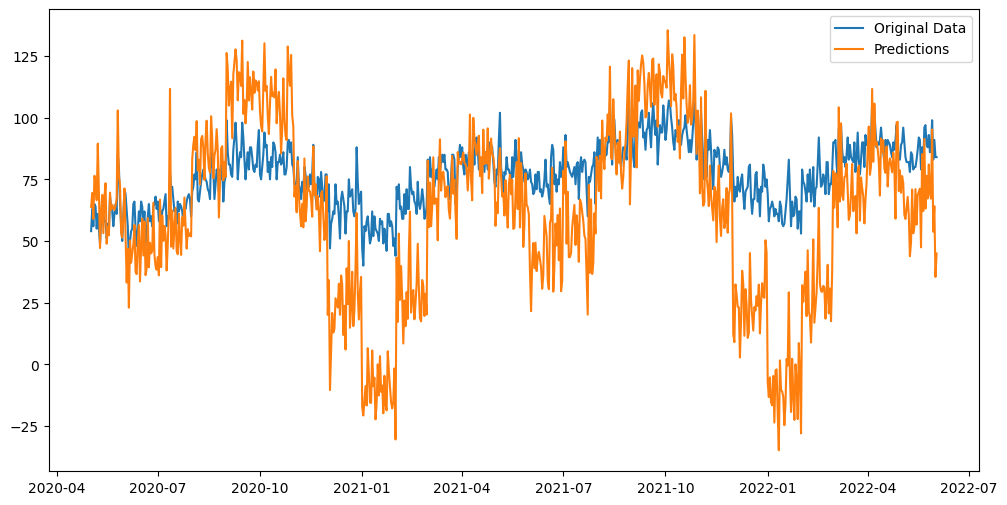

In [28]:
# Creating a figure with a specific size to display the plot
plt.figure(figsize=(12,6))

# Plotting the original 'orders' data
plt.plot(data_train["orders"], label="Original Data")

# Plotting the predictions
plt.plot(pred, label="Predictions")

# Adding legend to the plot
plt.legend()

# Showing the plot
plt.show()

In [29]:
# Calculating the difference of consecutive values in the 'orders' column to obtain the first-order difference
data_orders_diff = data_train["orders"].diff().dropna()

# Displaying the resulting first-order difference data
data_orders_diff

date
2020-05-03     9.0
2020-05-04    -7.0
2020-05-05     9.0
2020-05-06    -1.0
2020-05-07    -9.0
              ... 
2022-05-29    11.0
2022-05-30   -16.0
2022-05-31     8.0
2022-06-01    -7.0
2022-06-02     0.0
Freq: D, Name: orders, Length: 761, dtype: float64

In [30]:
# If test="ch", the Canova-Hansen (1995) test is used (with null hypothesis of deterministic seasonality)
# If test="ocsb", the Osborn-Chui-Smith-Birchenhall (1988) test is used (with null hypothesis that a seasonal unit root exists).

# Performing seasonal differencing using the Chapman-Kolmogorov and OCSB tests
ch = nsdiffs(x=data_train["orders"], m=7, test="ch")
ocsb = nsdiffs(x=data_train["orders"], m=7, test="ocsb")

# Printing the number of seasonal differences suggested by each test
print("ch:", ch)
print("ocsb:", ocsb)

ch: 0
ocsb: 0


In [31]:
# Applying the Augmented Dickey-Fuller (ADF) test to check for stationarity in the differenced data
adf = ADF(data_orders_diff, trend="ct")

# Printing the results of the ADF test
print(adf)

   Augmented Dickey-Fuller Results   
Test Statistic                 -8.866
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.97 (1%), -3.42 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [32]:
# Print the summary of the regression analysis performed using the Augmented Dickey-Fuller test
print(adf.regression.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     137.5
Date:                Thu, 08 Feb 2024   Prob (F-statistic):          1.62e-207
Time:                        11:51:38   Log-Likelihood:                -2438.9
No. Observations:                 746   AIC:                             4912.
Df Residuals:                     729   BIC:                             4990.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -4.1026      0.463     -8.866      0.0

In [33]:
# Initialize a TimeSeriesSplit object with 5 splits for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define a function to calculate mean squared error (MSE), root mean squared error (RMSE), and mean absolute error (MAE)
def error_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

# Holt's Linear Trend Model
mse = []
rmse = []
mae = []
for train_index, test_index in tscv.split(data_train["orders"]):
    train, test = data_train["orders"].iloc[train_index], data_train["orders"].iloc[test_index]
    model = Holt(train).fit(optimized=True, use_brute=True)
    y_pred = model.forecast(len(test))
    error = error_metrics(test, y_pred)
    mse.append(error[0])
    rmse.append(error[1])
    mae.append(error[2])
print("Holt Model - MSE: {} RMSE: {} MAE: {}".format(np.mean(mse), np.mean(rmse), np.mean(mae)))

# Holt-Winters Exponential Smoothing Model
mse = []
rmse = []
mae = []
for train_index, test_index in tscv.split(data_train["orders"]):
    train, test = data_train["orders"].iloc[train_index], data_train["orders"].iloc[test_index]
    model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).fit(optimized=True, use_brute=True)
    y_pred = model.forecast(len(test))
    error = error_metrics(test, y_pred)
    mse.append(error[0])
    rmse.append(error[1])
    mae.append(error[2])
print("Holt-Winters Model - MSE: {} RMSE: {} MAE: {}".format(np.mean(mse), np.mean(rmse), np.mean(mae)))

# ARIMA Model
mse = []
rmse = []
mae = []
for train_index, test_index in tscv.split(data_train["orders"]):
    train, test = data_train["orders"].iloc[train_index], data_train["orders"].iloc[test_index]
    model = auto_arima(train, trace=False, seasonal=False)
    y_pred = model.predict(len(test))
    error = error_metrics(test, y_pred)
    mse.append(error[0])
    rmse.append(error[1])
    mae.append(error[2])
print("ARIMA Model - MSE: {} RMSE: {} MAE: {}".format(np.mean(mse), np.mean(rmse), np.mean(mae)))

# SARIMA Model
mse = []
rmse = []
mae = []
for train_index, test_index in tscv.split(data_train["orders"]):
    try:
        train, test = data_train["orders"].iloc[train_index], data_train["orders"].iloc[test_index]
        model = auto_arima(train, trace=False, seasonal=True, m=7)
        y_pred = model.predict(len(test))
        error = error_metrics(test, y_pred)
        mse.append(error[0])
        rmse.append(error[1])
        mae.append(error[2])
    except ValueError:
        pass
print("SARIMA Model - MSE: {} RMSE: {} MAE: {}".format(np.mean(mse), np.mean(rmse), np.mean(mae)))

# ARIMAX Model
mse = []
rmse = []
mae = []
for train_index, test_index in tscv.split(data_train["orders"]):
    train, test = data_train["orders"].iloc[train_index], data_train["orders"].iloc[test_index]
    train_exog, test_exog = data_train["temperature"].iloc[train_index], data_train["temperature"].iloc[test_index]
    train_exog = np.array(train_exog).reshape(-1,1)
    test_exog = np.array(test_exog).reshape(-1,1)
    model = auto_arima(train, trace=False, seasonal=False, X=train_exog)
    y_pred = model.predict(len(test), X=test_exog)
    error = error_metrics(test, y_pred)
    mse.append(error[0])
    rmse.append(error[1])
    mae.append(error[2])
print("ARIMAX Model - MSE: {} RMSE: {} MAE: {}".format(np.mean(mse), np.mean(rmse), np.mean(mae)))

# SARIMAX Model
mse = []
rmse = []
mae = []
for train_index, test_index in tscv.split(data_train["orders"]):
    try:
        train, test = data_train["orders"].iloc[train_index], data_train["orders"].iloc[test_index]
        train_exog, test_exog = data_train["temperature"].iloc[train_index], data_train["temperature"].iloc[test_index]
        train_exog = np.array(train_exog).reshape(-1,1)
        test_exog = np.array(test_exog).reshape(-1,1)
        model = auto_arima(train, trace=False, seasonal=True, m=7, X=train_exog)
        y_pred = model.predict(len(test), X=test_exog)
        error = error_metrics(test, y_pred)
        mse.append(error[0])
        rmse.append(error[1])
        mae.append(error[2])
    except ValueError:
        pass
print("SARIMAX Model - MSE: {} RMSE: {} MAE: {}".format(np.mean(mse), np.mean(rmse), np.mean(mae)))


Holt Model - MSE: 1026.56159853747 RMSE: 28.69637163818576 MAE: 24.482544545791907
Holt-Winters Model - MSE: 464.15546851540347 RMSE: 20.550536766131646 MAE: 17.276225755078578
ARIMA Model - MSE: 372.4591775938487 RMSE: 18.591516052305284 MAE: 15.604679780429217
SARIMA Model - MSE: 432.4792787774244 RMSE: 19.50211076582074 MAE: 16.467417104088202
ARIMAX Model - MSE: 40.658550403268066 RMSE: 6.3083828229137575 MAE: 4.961612194532302
SARIMAX Model - MSE: 30.39155541206848 RMSE: 5.457991617542082 MAE: 4.333552844098797


In [34]:
# Automatically selecting SARIMAX model parameters using auto_arima
model = auto_arima(data_train["orders"],
                   seasonal=True, m=7,
                   max_d=2, max_D=2,
                   max_p=3, max_q=3,
                   max_P=3, max_Q=3,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   X=data_train[["temperature", "media_spend"]])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4809.115, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4639.323, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4439.254, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4807.167, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=4548.954, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=4375.334, Time=0.94 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=4162.306, Time=2.22 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=4128.051, Time=2.89 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=4144.273, Time=2.01 sec
 ARIMA(0,1,1)(3,0,2)[7] intercept   : AIC=4130.725, Time=3.41 sec
 ARIMA(0,1,1)(2,0,3)[7] intercept   : AIC=4131.509, Time=3.65 sec
 ARIMA(0,1,1)(1,0,3)[7] intercept   : AIC=inf, Time=3.49 sec
 ARIMA(0,1,1)(3,0,1)[7] intercept   : AIC=4147.5

In [35]:
# Print model summary by auto_arima
print(model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  762
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -2055.026
Date:                                Thu, 08 Feb 2024   AIC                           4128.051
Time:                                        11:57:34   BIC                           4169.763
Sample:                                    05-02-2020   HQIC                          4144.113
                                         - 06-02-2022                                         
Covariance Type:                                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       0.0004      0.000      0.867      0.386      -0.001       0.001


In [165]:
# Define starting values for the best model
order_aic_bic = []

# Suppress warnings
warnings.filterwarnings("ignore")

# Define parameter ranges
p_range = range(0, 3)
q_range = range(0, 3)
P_range = range(0, 3)
Q_range = range(0, 3)
d_range = range(0, 3)
# D_range = range(0, 3)
D = 0


# Apply grid search
for p, d, q, P, Q in itertools.product(p_range, q_range, P_range, Q_range, d_range):

    try:
        # Fit SARIMAX model with specified parameters
        mod = SARIMAX(data_train['orders'], order=(p, d, q), seasonal_order=(P, D, Q, 7), exog=data_train[["temperature", "media_spend"]])
        results = mod.fit() 
        
        # Calculate AIC and BIC
        aic = results.aic
        bic = results.bic
        order_aic_bic.append((p, d, q, P, D, Q, aic, bic))
        
    except:
        continue

# Re-enable warnings
warnings.filterwarnings("default")

# Print the best model
order_df = pd.DataFrame(order_aic_bic, columns=["p", "d", "q", "P", "D", "Q", "AIC", "BIC"])
print("Best models sorted by AIC:")
print(order_df.sort_values("AIC"))
print("\nBest models sorted by BIC:")
print(order_df.sort_values("BIC"))

Best models sorted by AIC:
     p  d  q  P  D  Q          AIC          BIC
79   0  2  2  2  0  1  4105.765303  4142.831851
157  1  2  2  1  0  1  4105.840192  4142.906739
160  1  2  2  2  0  1  4106.691537  4148.391403
158  1  2  2  1  0  2  4112.976603  4154.676469
76   0  2  2  1  0  1  4113.319742  4145.752971
..  .. .. .. .. .. ..          ...          ...
10   0  0  1  0  0  1  6466.308803  6489.488536
2    0  0  0  0  0  2  6521.160299  6544.340032
9    0  0  1  0  0  0  6786.505516  6805.049303
1    0  0  0  0  0  1  6870.203321  6888.747108
0    0  0  0  0  0  0  7384.093767  7398.001606

[243 rows x 8 columns]

Best models sorted by BIC:
     p  d  q  P  D  Q          AIC          BIC
79   0  2  2  2  0  1  4105.765303  4142.831851
157  1  2  2  1  0  1  4105.840192  4142.906739
40   0  1  1  1  0  1  4115.131681  4142.939481
76   0  2  2  1  0  1  4113.319742  4145.752971
160  1  2  2  2  0  1  4106.691537  4148.391403
..  .. .. .. .. .. ..          ...          ...
10   0  0

In [166]:
order_df.sort_values("AIC").head(10)

,p,d,q,P,D,Q,AIC,BIC
79,0,2,2,2,0,1,4105.765303,4142.831851
157,1,2,2,1,0,1,4105.840192,4142.906739
160,1,2,2,2,0,1,4106.691537,4148.391403
158,1,2,2,1,0,2,4112.976603,4154.676469
76,0,2,2,1,0,1,4113.319742,4145.752971
80,0,2,2,2,0,2,4113.348455,4155.048321
161,1,2,2,2,0,2,4114.537042,4160.870226
214,2,1,2,2,0,1,4114.817493,4161.163827
40,0,1,1,1,0,1,4115.131681,4142.939481
133,1,1,2,2,0,1,4116.094200,4157.805900


In [167]:
# Suppressing warnings
warnings.filterwarnings("ignore")

# Creating SARIMAX model with specified parameters and exogenous variable
sarimax = SARIMAX(data_train["orders"], exog=data_train[["temperature", "media_spend"]], order=(0, 2, 2), seasonal_order=(2, 0, 1, 7))

# Fitting SARIMAX model
model_sarimax = sarimax.fit()

# Printing the summary of the SARIMAX model
print(model_sarimax.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              orders   No. Observations:                  762
Model:             SARIMAX(0, 2, 2)x(2, 0, [1], 7)   Log Likelihood               -2044.883
Date:                             Thu, 08 Feb 2024   AIC                           4105.765
Time:                                     12:47:24   BIC                           4142.832
Sample:                                 05-02-2020   HQIC                          4120.039
                                      - 06-02-2022                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature     0.9515      0.006    154.233      0.000       0.939       0.964
media_spend     1.0233  

In [168]:
# If the p-value is less than a chosen significance level (commonly 0.05), it indicates that there is significant autocorrelation present in the residuals.
# If the p-value is greater than the significance level, it suggests that there is no significant autocorrelation in the residuals.

# Perform Ljung-Box test on the residuals of the SARIMAX model
ljung_box = acorr_ljungbox(model_sarimax.resid)

# Print the results of the Ljung-Box test
ljung_box

,lb_stat,lb_pvalue
1,0.261003,0.609432
2,3.134849,0.208582
3,3.151734,0.368817
4,3.160444,0.531344
5,6.631936,0.249484
6,6.982803,0.322441
7,6.987153,0.430219
8,8.877265,0.352755
9,8.987312,0.438446
10,9.020605,0.530149


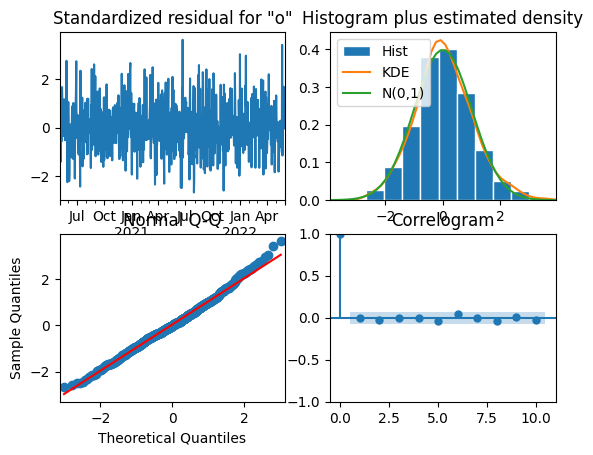

In [169]:
# Visualize diagnostics plots for the SARIMAX model
model_sarimax.plot_diagnostics()

# Show the plots
plt.show()

In [170]:
# Generate train data set predictions using the SARIMAX model with exogenous variable
predictions_train = model_sarimax.predict(exog=data_train[["temperature", "media_spend"]], start=data_train.index[0], end=data_train.index[len(data_train)-1])

# Create a DataFrame to store observed and predicted values
df_observed = pd.DataFrame()
df_observed["Observed Orders"] = data_train["orders"]
df_observed["SARIMAX Predictions"] = predictions_train

# Display the DataFrame
df_observed

,Observed Orders,SARIMAX Predictions
date,,
2020-05-02,54.0,17.383375
2020-05-03,63.0,73.841793
2020-05-04,56.0,67.609593
2020-05-05,65.0,64.357135
2020-05-06,64.0,65.933832
...,...,...
2022-05-29,99.0,93.926332
2022-05-30,83.0,83.115694
2022-05-31,91.0,89.865967


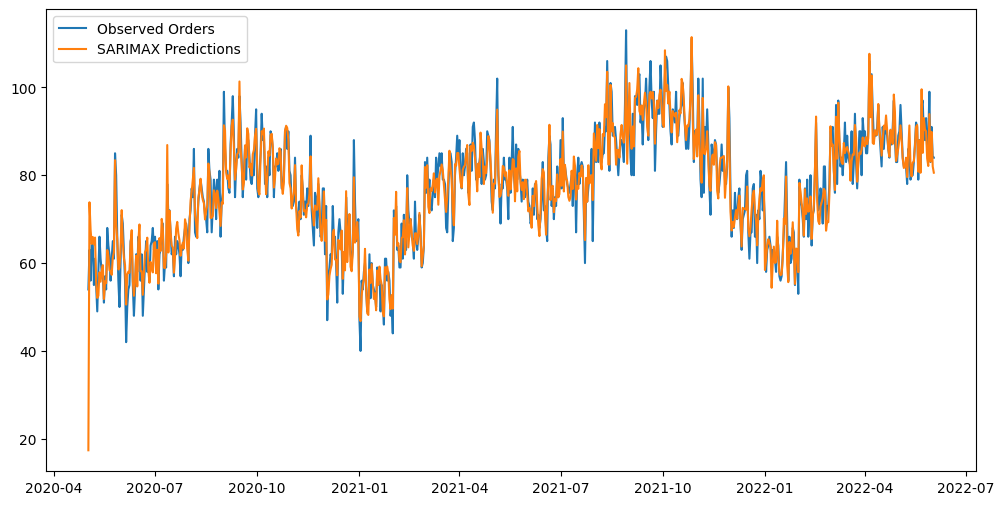

In [171]:
# Plot observed and predicted values from the SARIMAX model
plt.figure(figsize=(12,6))
plt.plot(df_observed)
plt.legend(df_observed.columns)
plt.show()

In [172]:
# Generate test data set forecasted values for future time periods using the SARIMAX model with exogenous variable
forecast_future_test = model_sarimax.forecast(len(data_test), exog=data_test[["temperature", "media_spend"]])

# Create a DataFrame to store forecasted values for unseen future data
df_unseen_test = pd.DataFrame()
df_unseen_test["SARIMAX Predictions"] = forecast_future_test.values

# Change the index of the second DataFrame
df_unseen_test.index = pd.date_range(start=df_observed.index[-1] + pd.Timedelta(days=1), periods=len(df_unseen_test), name="date")

# Display the DataFrame
df_unseen_test

,SARIMAX Predictions
date,
2022-06-03,78.697585
2022-06-04,72.467385
2022-06-05,80.122256
2022-06-06,82.408572
2022-06-07,81.325198
2022-06-08,83.564219
2022-06-09,87.102256
2022-06-10,75.648514
2022-06-11,83.663571


In [173]:
# Concatenate the two DataFrames
train_test_result_df = pd.concat([df_observed, df_unseen_test], ignore_index=False)

# Show the result
train_test_result_df

,Observed Orders,SARIMAX Predictions
date,,
2020-05-02,54.0,17.383375
2020-05-03,63.0,73.841793
2020-05-04,56.0,67.609593
2020-05-05,65.0,64.357135
2020-05-06,64.0,65.933832
...,...,...
2022-06-12,NaN,79.719552
2022-06-13,NaN,80.404527
2022-06-14,NaN,84.284504


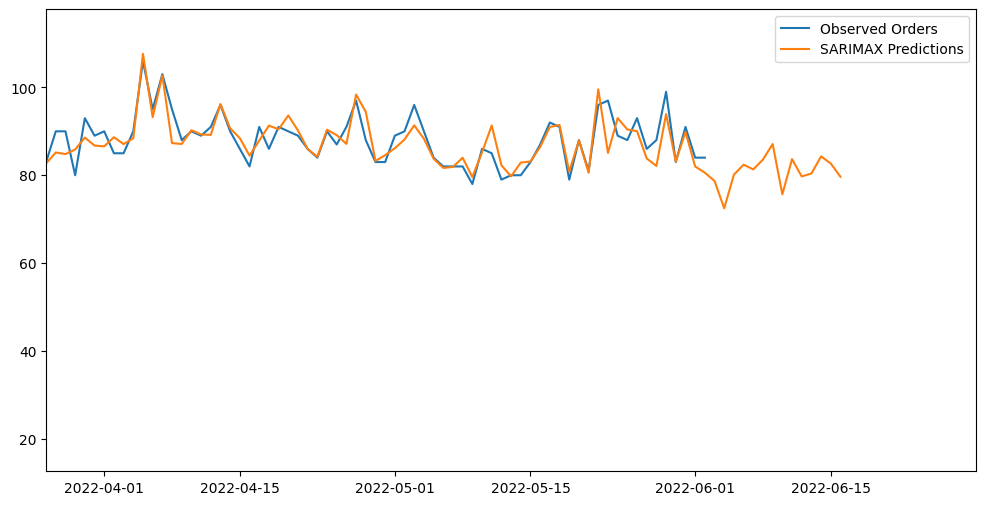

In [174]:
# After creating the plot, select a specific date range using xlim
plt.figure(figsize=(12,6))
plt.plot(train_test_result_df)
plt.legend(train_test_result_df.columns)

# Convert the date range to datetime objects
date_range = pd.to_datetime(['2022-03-26', '2022-06-30'])

# Limit the plot to the specified date range
plt.xlim(date_range)

# Show the plots
plt.show()


In [175]:
# Define a function to calculate error metrics between observed and predicted values
def calculate_error(y, prediction):
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, prediction)
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, prediction)
    
    return mse, rmse, mae

In [176]:
# Calculate error metrics between observed and predicted values using the defined function
error_metrics = calculate_error(data_train["orders"], predictions_train)

# Display the error metrics
error_metrics

(14.753083725462385, 3.8409743198129283, 2.840186551723505)

In [177]:
# Calculate error metrics between observed and forecasted values using the defined function
error_metrics_test = calculate_error(data_test["orders"], forecast_future_test)

# Display the error metrics
error_metrics_test

(10.596952070522203, 3.255296003518298, 2.750804970030931)

In [179]:
# Suppressing warnings
warnings.filterwarnings("ignore")

# Creating SARIMAX model with specified parameters and exogenous variable
sarimax = SARIMAX(orders["orders"], exog=orders[["temperature", "media_spend"]], order=(0, 2, 2), seasonal_order=(2, 0, 1, 7))

# Fitting SARIMAX model
model_sarimax = sarimax.fit()

# Printing the summary of the SARIMAX model
print(model_sarimax.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              orders   No. Observations:                  776
Model:             SARIMAX(0, 2, 2)x(2, 0, [1], 7)   Log Likelihood               -2081.848
Date:                             Thu, 08 Feb 2024   AIC                           4179.695
Time:                                     12:48:08   BIC                           4216.908
Sample:                                 05-02-2020   HQIC                          4194.013
                                      - 06-16-2022                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature     0.9569      0.009    108.956      0.000       0.940       0.974
media_spend     1.0254  

In [180]:
# If the p-value is less than a chosen significance level (commonly 0.05), it indicates that there is significant autocorrelation present in the residuals.
# If the p-value is greater than the significance level, it suggests that there is no significant autocorrelation in the residuals.

# Perform Ljung-Box test on the residuals of the SARIMAX model
ljung_box = acorr_ljungbox(model_sarimax.resid)

# Print the results of the Ljung-Box test
ljung_box

,lb_stat,lb_pvalue
1,0.188538,0.664136
2,2.814853,0.244772
3,2.822550,0.419801
4,2.823159,0.587842
5,6.364850,0.272318
6,6.693696,0.350105
7,6.695729,0.461233
8,8.702549,0.368007
9,8.862954,0.450020
10,8.901615,0.541466


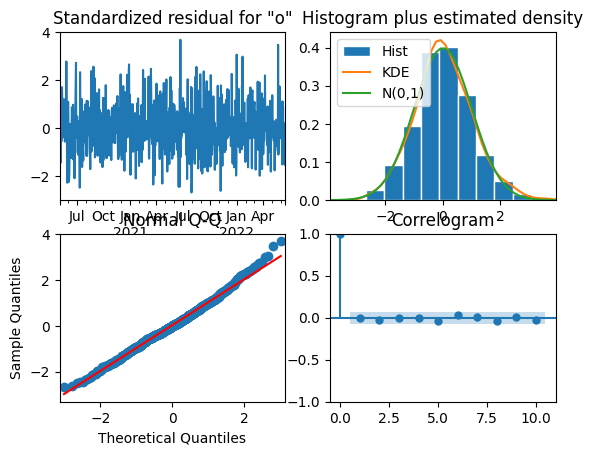

In [181]:
# Visualize diagnostics plots for the SARIMAX model
model_sarimax.plot_diagnostics()

# Show the plots
plt.show()

In [182]:
# Generate predictions using the SARIMAX model with exogenous variable
predictions = model_sarimax.predict(exog=orders[["temperature", "media_spend"]], start=orders.index[0], end=orders.index[len(orders)-1])

# Create a DataFrame to store observed and predicted values
df = pd.DataFrame()
df["Observed Orders"] = orders["orders"]
df["SARIMAX Predictions"] = predictions

# Display the DataFrame
df

,Observed Orders,SARIMAX Predictions
date,,
2020-05-02,54.0,17.483065
2020-05-03,63.0,73.800766
2020-05-04,56.0,67.584289
2020-05-05,65.0,64.383783
2020-05-06,64.0,65.933437
...,...,...
2022-06-12,76.0,79.452523
2022-06-13,78.0,80.062448
2022-06-14,79.0,84.079759


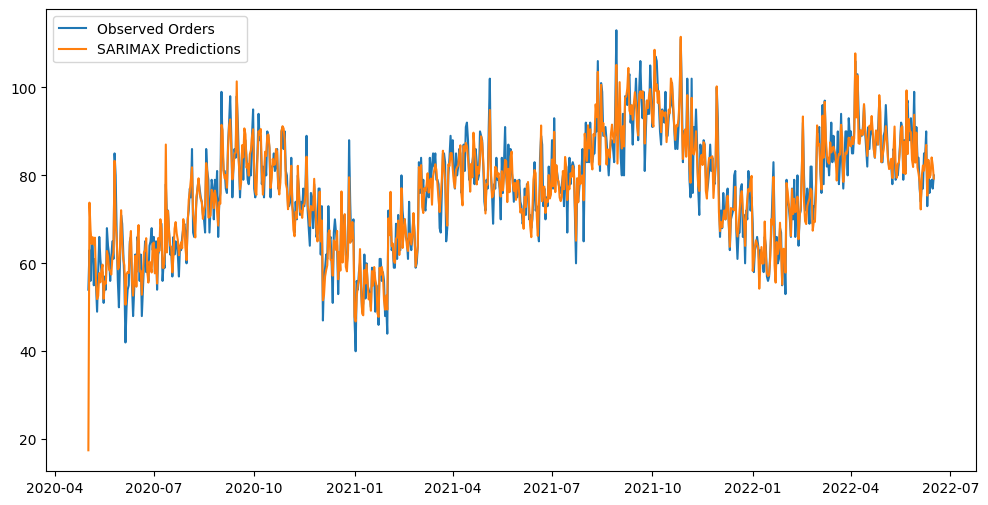

In [183]:
# Plot observed and predicted values from the SARIMAX model
plt.figure(figsize=(12,6))
plt.plot(df)
plt.legend(df.columns)
plt.show()

In [184]:
# Generate forecasted values for future time periods using the SARIMAX model with exogenous variable
forecast_future = model_sarimax.forecast(len(orders_unseen), exog=orders_unseen[["temperature", "media_spend"]])

# Create a DataFrame to store forecasted values for unseen future data
df_unseen = pd.DataFrame()
df_unseen["SARIMAX Predictions"] = forecast_future.values

# Change the index of the second DataFrame
df_unseen.index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=len(df_unseen), name="date")

# Display the DataFrame
df_unseen

,SARIMAX Predictions
date,
2022-06-17,76.831923
2022-06-18,78.964894
2022-06-19,78.993900
2022-06-20,81.053056
2022-06-21,89.956631
2022-06-22,83.836471
2022-06-23,99.780709
2022-06-24,77.991417
2022-06-25,88.752593


In [185]:
# Concatenate the two DataFrames
result_df = pd.concat([df, df_unseen], ignore_index=False)

# Show the result
result_df

,Observed Orders,SARIMAX Predictions
date,,
2020-05-02,54.0,17.483065
2020-05-03,63.0,73.800766
2020-05-04,56.0,67.584289
2020-05-05,65.0,64.383783
2020-05-06,64.0,65.933437
...,...,...
2022-06-26,NaN,80.740930
2022-06-27,NaN,78.476143
2022-06-28,NaN,91.014397


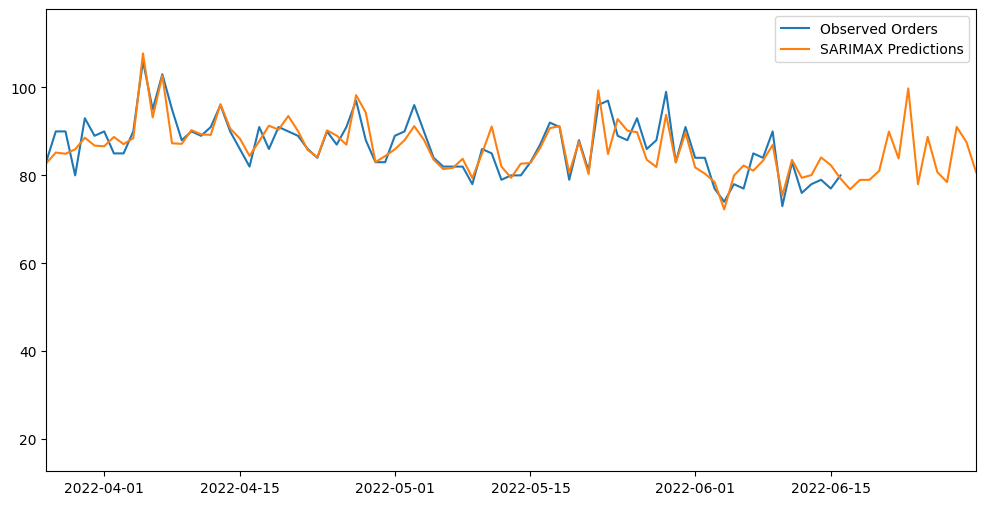

In [186]:
# After creating the plot, select a specific date range using xlim
plt.figure(figsize=(12,6))
plt.plot(result_df)
plt.legend(result_df.columns)

# Convert the date range to datetime objects
date_range = pd.to_datetime(['2022-03-26', '2022-06-30'])

# Limit the plot to the specified date range
plt.xlim(date_range)

# Show the plots
plt.show()

In [187]:
# Concatenate the two DataFrames
result_df = pd.concat([df, df_unseen], ignore_index=False)

# Show the result
result_df

,Observed Orders,SARIMAX Predictions
date,,
2020-05-02,54.0,17.483065
2020-05-03,63.0,73.800766
2020-05-04,56.0,67.584289
2020-05-05,65.0,64.383783
2020-05-06,64.0,65.933437
...,...,...
2022-06-26,NaN,80.740930
2022-06-27,NaN,78.476143
2022-06-28,NaN,91.014397


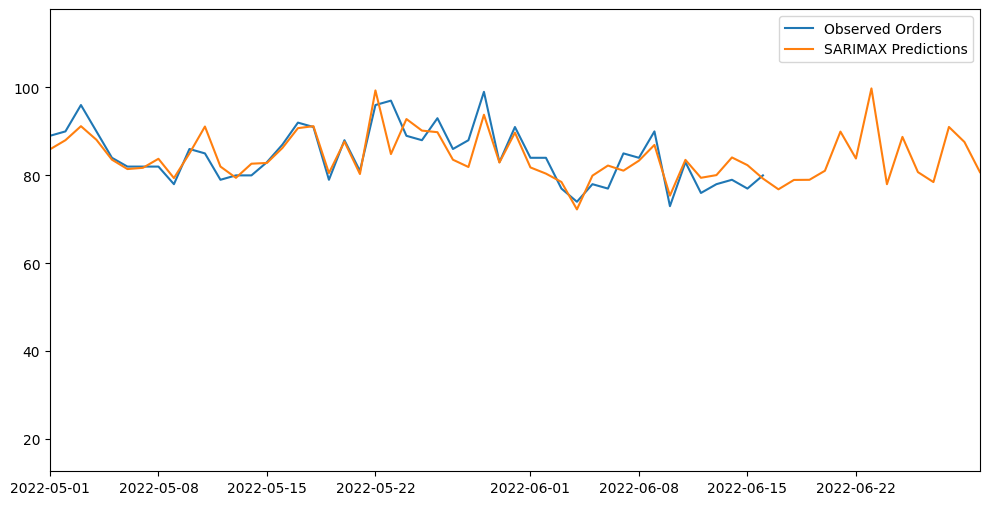

In [188]:
# After creating the plot, select a specific date range using xlim
plt.figure(figsize=(12,6))
plt.plot(result_df)
plt.legend(result_df.columns)

# Convert the date range to datetime objects
date_range = pd.to_datetime(['2022-05-01', '2022-06-30'])

# Limit the plot to the specified date range
plt.xlim(date_range)

# Show the plots
plt.show()


In [189]:
# Calculate error metrics between observed and predicted values using the defined function
error_metrics = calculate_error(orders["orders"], predictions)

# Display the error metrics
error_metrics

(14.688423465395374, 3.832547907775632, 2.8422730573901984)

In [190]:
# Assigning the index values to the 'date' column
df_unseen["date"] = df_unseen.index

# Renaming the column 'SARIMAX Predictions' to 'orders'
df_unseen.rename(columns={"SARIMAX Predictions": "orders"}, inplace=True)

# Resetting the index and dropping the old index column
df_unseen.reset_index(drop=True, inplace=True)

# Defining the new order of columns
new_order = ['date', 'orders']

# Reindexing the DataFrame based on the new column order
df_unseen = df_unseen.reindex(columns=new_order)

# Displaying the updated DataFrame
df_unseen

,date,orders
0,2022-06-17,76.831923
1,2022-06-18,78.964894
2,2022-06-19,78.993900
3,2022-06-20,81.053056
4,2022-06-21,89.956631
5,2022-06-22,83.836471
6,2022-06-23,99.780709
7,2022-06-24,77.991417
8,2022-06-25,88.752593
9,2022-06-26,80.740930


In [191]:
# Save the DataFrame to a CSV file named 'submission.csv' without including the index
df_unseen.to_csv('submission.csv', index=False)

In [192]:
# Read the CSV file 'submission.csv' into a DataFrame
sub1 = pd.read_csv("submission.csv")

# Display the DataFrame
sub1

,date,orders
0,2022-06-17,76.831923
1,2022-06-18,78.964894
2,2022-06-19,78.993900
3,2022-06-20,81.053056
4,2022-06-21,89.956631
5,2022-06-22,83.836471
6,2022-06-23,99.780709
7,2022-06-24,77.991417
8,2022-06-25,88.752593
9,2022-06-26,80.740930
